# Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
from shapely.geometry import Point
from shapely.geometry import LineString
import seaborn as sns

# Defining paths

In [2]:
data_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data'
# animal = '20211204/mouse_02_IL'
list_animal = ['20211204/mouse_02_IL', '20211206/mouse_02_IL', '20211204/mouse_01_CA1']

# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_01_CA1'
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_02_IL'
# path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
# path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Parameters

In [3]:
n_bins = 20
color_palette = np.array(sns.color_palette('Spectral_r', n_bins))

# Functions

In [4]:
def loadAll(animal):
    
    global meta_spikes, df_dlc, mat_spikes, df_frames, dict_meta, reference_points, path_pickle, path_table, path_mat_spikes, cur_dir
    
    cur_dir = os.path.join(data_dir, animal)
    path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
    path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')    
    path_pickle = os.path.join(cur_dir, 'pickle')
    
    with open(os.path.join(path_pickle, 'meta_spikes.pck'), 'rb') as f:
        meta_spikes = pickle.load(f)
    with open(os.path.join(path_pickle, 'df_dlc_projections.pck'), 'rb') as f:
        df_dlc = pickle.load(f)
    with open(os.path.join(path_pickle, 'mat_spikes.pck'), 'rb') as f:
        mat_spikes = pickle.load(f)
    with open(os.path.join(path_pickle, 'df_frames.pck'), 'rb') as f:
        df_frames = pickle.load(f)
    with open(os.path.join(path_pickle, 'dict_meta.pck'), 'rb') as f:
        dict_meta = pickle.load(f)
    with open(os.path.join(path_pickle, 'reference_points.pck'), 'rb') as f:
        reference_points = pickle.load(f)
        
    df_dlc_axis = df_dlc[['closest_arm', 'projection', 'environment']]
    meta_spikes = meta_spikes.join(df_dlc_axis, on = 'behavioral_frame')
    
    
def plotArm(dict_arm):    

    c = reference_points[dict_arm['mode']]
    max_val = np.max([np.max(d) if k != 'mode' else 0 for (k,d) in dict_arm.items()])
    bins_colorpalette = np.linspace(0, max_val+0.00000001, num = n_bins + 1)

    for arm in ['middle', 'left', 'right']:

        if arm == 'middle':
            xe = c['x_m']
            ye = c['y_m']
        elif arm == 'left':
            xe = c['x_l']
            ye = c['y_l']
        elif arm == 'right':
            xe = c['x_r']
            ye = c['y_r']

        x_vect = np.linspace(c['x_c'], xe, num=n_bins)
        y_vect = np.linspace(c['y_c'], ye, num=n_bins)

        color_code = np.digitize(dict_arm[arm], bins_colorpalette)

        plt.scatter(x_vect, y_vect, c = color_palette[color_code-1], s = 50)
        plt.gca().set_aspect('equal')

    plt.axis('off')

# Heatmaps analysis

In [5]:
hist_edges = np.linspace(0, 1.0001, num = n_bins + 1)

### Plotting time spent

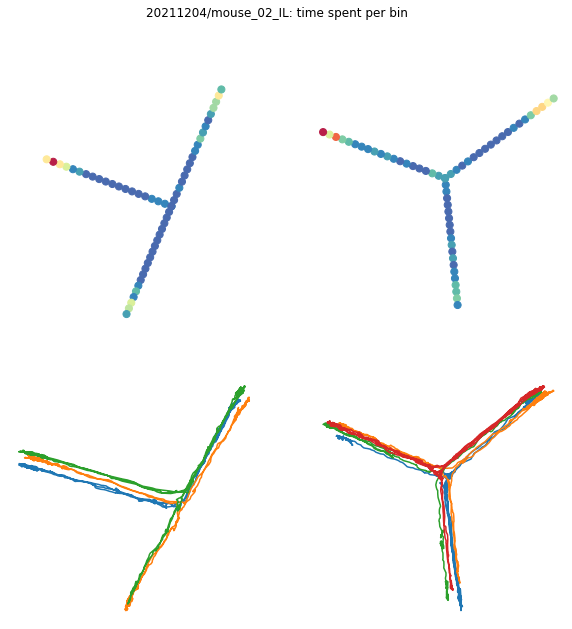

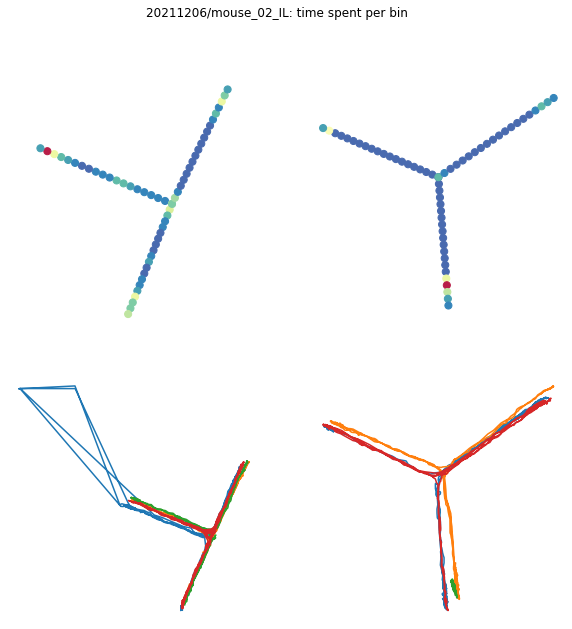

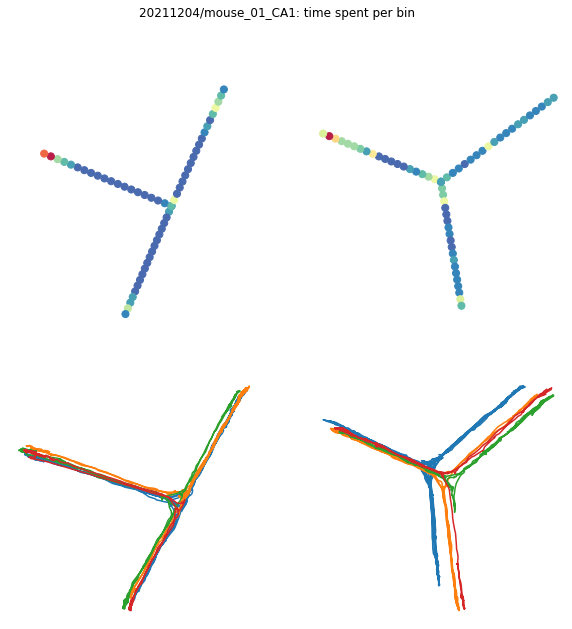

In [38]:
for animal in list_animal:
    
    loadAll(animal)
    list_dict_arms = list()
    
    for env in ['t_maze', 'y_maze']:
        sub_spikes = meta_spikes.query('environment == @env')
        dict_arm = {'mode': env}
        for arm in ['middle', 'left', 'right']:
            sub_arm = sub_spikes.query('closest_arm == @arm')
            sample_counts, _ = np.histogram(sub_arm['projection'], hist_edges)
            dict_arm[arm] = sample_counts
        list_dict_arms.append(dict_arm)
        
    plt.figure(figsize = (10,10))
    plt.suptitle(animal + ': time spent per bin')

    for i,dict_arm in enumerate(list_dict_arms):
        cur_ax = plt.subplot(2, len(list_dict_arms), i+1)
        plotArm(dict_arm)
        plt.gca().invert_yaxis()
        
    for i,dict_arm in enumerate(list_dict_arms):
        cur_ax = plt.subplot(2, len(list_dict_arms), i+1+len(list_dict_arms))
        env = dict_arm['mode']
        cur_meta = meta_spikes.query('environment == @env')
        for sess in pd.unique(cur_meta['session']):
            sub_meta = cur_meta.query('session == @sess')
            plt.plot(sub_meta['x'], sub_meta['y'])        
        plt.axis('off')
        plt.gca().invert_yaxis()


## Plotting activity

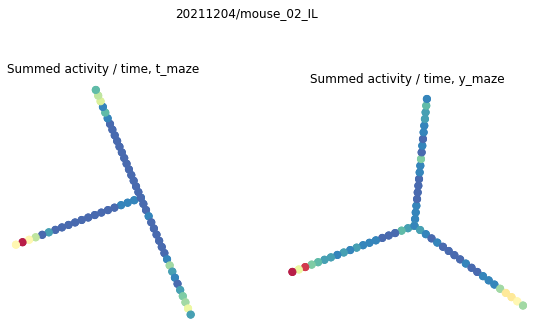

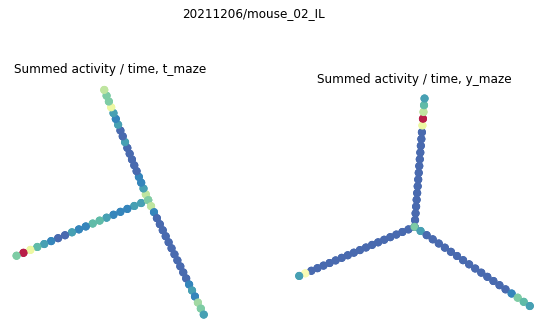

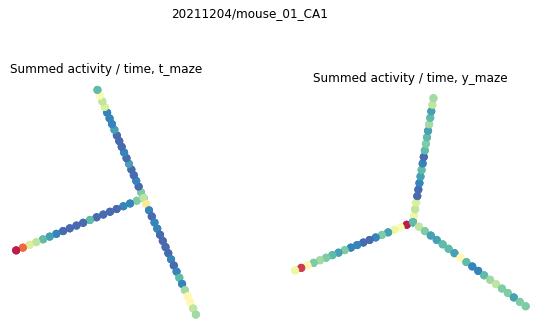

In [60]:
for animal in list_animal:
    
    loadAll(animal)
    list_dict_arms = list()
    list_dict_arms_rate = list()
    
    for env in ['t_maze', 'y_maze']:
        
        sub_spikes = meta_spikes.query('environment == @env')
        dict_arm = {'mode': env}
        dict_arms_rate = {'mode': env}
        
        for arm in ['middle', 'left', 'right']:
            
            sub_arm = sub_spikes.query('closest_arm == @arm').copy()
            sample_counts, _ = np.histogram(sub_arm['projection'], hist_edges)
            sub_arm['bin_assignment'] = np.digitize(sub_arm['projection'], hist_edges) - 1
            summed_activity_binned = np.zeros(n_bins)
            
            for i,r in sub_arm.iterrows():
                summed_activity_binned[r['bin_assignment']] += np.sum(mat_spikes[i,:])
                
            dict_arm[arm] = summed_activity_binned  
            dict_arms_rate[arm] = summed_activity_binned / sample_counts
            
        list_dict_arms.append(dict_arm)
        list_dict_arms_rate.append(dict_arm)
        
    plt.figure(figsize = (10,10))
    plt.suptitle(animal)

    for i,dict_arm in enumerate(list_dict_arms):
        cur_ax = plt.subplot(2, len(list_dict_arms), i+1)
        plotArm(dict_arm)
        plt.gca().invert_yaxis()
        plt.title('Summed activity, ' + dict_arm['mode'])

    for i,dict_arm in enumerate(list_dict_arms_rate):
        cur_ax = plt.subplot(2, len(list_dict_arms_rate), i+1)
        plotArm(dict_arm)
        plt.gca().invert_yaxis()
        plt.title('Summed activity / time, ' + dict_arm['mode'])
